In [1]:
import numpy as np
import pandas as pd
from vtl.Readfile import Readfile
from spec_id import RT_spec,Gen_spec, Analyze_LH,Median_w_Error_cont,Leave_one_out
import matplotlib.pyplot as plt
from astropy.cosmology import Planck13, z_at_value
from astropy.table import Table
from astropy.io import fits
import astropy
from astropy import units as u
from astropy.cosmology import WMAP9 as cosmo
import os
import cPickle
import seaborn as sea
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in","ytick.direction": "in"})
colmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.1, as_cmap=True)

In [2]:
galDB = pd.read_pickle('../data/sgal_param_DB.pkl')
metal=np.arange(0.002,0.031,0.001)
age=np.arange(.5,6.1,.1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
M,A=np.meshgrid(metal,age)

In [3]:
lzDB = galDB.query('hi_res_specz < 1.16')
mzDB = galDB.query('1.16 < hi_res_specz < 1.3')
mzDB = mzDB.query('ids != 14713 and ids != 38126')
hzDB = galDB.query('1.3 < hi_res_specz < 1.45')
uhzDB = galDB.query('1.45 < hi_res_specz')
gmtlDB = galDB.query('1.45 > hi_res_specz')
gmtlDB = gmtlDB.query('ids != 14713 and ids != 38126')

In [49]:
"""DATA"""

def Bootstrap_errors_lfit(masses,metals,ers,sampling=np.arange(10,11.75,.01),its=1000):
    l_grid = np.zeros([its,len(sampling)])
    IDs = np.arange(len(masses))
    for i in range(its):
        IDn = np.random.choice(IDs,len(IDs),replace=True)
        lvals = np.polyfit(masses[IDn],np.log10(metals[IDn]/.019),1,w = 1/ers[IDn]**2)
        lfit = np.polyval(lvals,sampling)
        l_grid[i] = lfit
        
    m_fit = np.mean(l_grid,axis=0)
    low_ers = np.zeros(len(samp))
    hi_ers = np.zeros(len(samp))
    
    for i in range(len(l_grid.T)):
        low_ers[i] = np.sort(l_grid.T[i])[150]
        hi_ers[i] = np.sort(l_grid.T[i])[830]
    return low_ers,hi_ers, m_fit

Pl_grid,Pm_grid,Ph_grid,Puh_grid = [[],[],[],[]]
for i in lzDB.index:
    x,Px = np.load('../chidat/%s_dtau_Z_pos_lwa.npy' % lzDB['gids'][i])
    Pl_grid.append(Px)
 
for i in mzDB.index:
    x,Px = np.load('../chidat/%s_dtau_Z_pos_lwa.npy' % mzDB['gids'][i])
    Pm_grid.append(Px)

for i in hzDB.index:
    x,Px = np.load('../chidat/%s_dtau_Z_pos_lwa.npy' % hzDB['gids'][i])
    Ph_grid.append(Px)

for i in uhzDB.index:
    x,Px = np.load('../chidat/%s_dtau_Z_pos_lwa.npy' % uhzDB['gids'][i])
    Puh_grid.append(Px)

Pl_grid = np.array(Pl_grid)
Pm_grid = np.array(Pm_grid)
Ph_grid = np.array(Ph_grid)
Puh_grid = np.array(Puh_grid)

W = Leave_one_out(Pl_grid,metal)
top = np.zeros(Pl_grid.shape)
for i in range(W.size):
    top[i] = W[i] * Pl_grid[i]
Pl =sum(top)/sum(W)
Pl /= np.trapz(Pl,metal)

W = Leave_one_out(Pm_grid,metal)
top = np.zeros(Pm_grid.shape)
for i in range(W.size):
    top[i] = W[i] * Pm_grid[i]
Pm =sum(top)/sum(W)
Pm /= np.trapz(Pm,metal)

W = Leave_one_out(Ph_grid,metal)
top = np.zeros(Ph_grid.shape)
for i in range(W.size):
    
    top[i] = W[i] * Ph_grid[i]
Ph =sum(top)/sum(W)
Ph /= np.trapz(Ph,metal)

W = Leave_one_out(Puh_grid,metal)
top = np.zeros(Puh_grid.shape)
for i in range(W.size):
    top[i] = W[i] * Puh_grid[i]
Puh =sum(top)/sum(W)
Puh /= np.trapz(Puh,metal)

lmed,ller,lher=Median_w_Error_cont(Pl,metal)
mmed,mler,mher=Median_w_Error_cont(Pm,metal)
hmed,hler,hher=Median_w_Error_cont(Ph,metal)
uhmed,uhler,uhher=Median_w_Error_cont(Puh,metal)

logm,gmetal=Readfile('../data/Gallazzi_12.dat',0)
cvx,cvy=Readfile('../data/Gallazzi_12_line.dat',0)
cv1x,cv1y=Readfile('../data/gallazzi_points_curve1.dat',0)

lZ=np.array(lzDB['Zx_lwa'])
mZ=np.array(mzDB['Zx_lwa'])
hZ=np.array(hzDB['Zx_lwa'])
uhZ=np.array(uhzDB['Zx_lwa'])
gmtlZ=np.array(gmtlDB['Zx_lwa'])

lerrs = gmtlDB['Zx_-_sig_lwa']/(gmtlDB['Zx_lwa'] * np.log(10))
herrs = gmtlDB['Zx_+_sig_lwa']/(gmtlDB['Zx_lwa'] * np.log(10))
errs = (gmtlDB['Zx_-_sig_lwa'] + gmtlDB['Zx_+_sig_lwa']/2) / (gmtlDB['Zx_lwa'] * np.log(10))
lvals,cov = np.polyfit(gmtlDB['lmass'],np.log10(gmtlZ/.019),1,w = 1/errs**2,cov=True)

lfit = np.polyval(lvals,np.arange(10,11.75,.01))

samp = np.arange(10,11.75,.01)
low_ers,hi_ers,m_fit = Bootstrap_errors_lfit(gmtlDB['lmass'].values,gmtlZ,errs.values,sampling=samp)

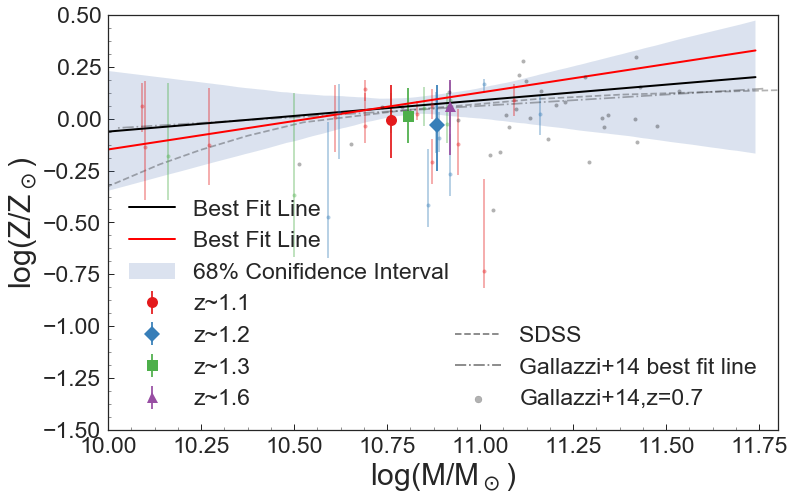

In [5]:
###PLOT
%matplotlib inline

plt.figure(figsize=[12,8])
currentAxis = plt.gca()

####gallazzi points
plt.plot(cv1x,cv1y,'--',zorder=1,color='k',alpha=.3,markersize=4)
sdss=plt.axhline(y=5,linestyle='--',color='k',alpha=.5)
plt.plot(cvx,cvy,zorder=2,linestyle='-.',color='k',alpha=.3,ms=4)
galbf=plt.axhline(y=5,linestyle='-.',color='k',alpha=.5)
plt.plot(logm,gmetal,'o',zorder=3,color='k',alpha=.3,markersize=4)
galpts = plt.scatter(100,100,marker='o',zorder=3,color='k',alpha=.3)#,label='Gallazzi+14,z=0.7')
legend1 = plt.legend([sdss,galbf,galpts],['SDSS','Gallazzi+14 best fit line','Gallazzi+14,z=0.7'],loc = 4,fontsize=23)
currentAxis.add_artist(legend1)
#####single galaxy points

plt.errorbar(lzDB['lmass'],np.log10(lZ/0.019), yerr=[lzDB['Zx_-_sig_dt']/(lzDB['Zx_dt'] * np.log(10)),lzDB['Zx_+_sig_dt']/(lzDB['Zx_dt'] * np.log(10))]
             ,color='#e41a1c',alpha=.4,ms=4,fmt='o')
plt.errorbar(mzDB['lmass'],np.log10(mZ/0.019), yerr=[mzDB['Zx_-_sig_dt']/(mzDB['Zx_dt'] * np.log(10)),mzDB['Zx_+_sig_dt']/(mzDB['Zx_dt'] * np.log(10))]
             ,color='#377eb8',alpha=.4,ms=4,fmt='o')
plt.errorbar(hzDB['lmass'],np.log10(hZ/0.019), yerr=[hzDB['Zx_-_sig_dt']/(hzDB['Zx_dt'] * np.log(10)),hzDB['Zx_+_sig_dt']/(hzDB['Zx_dt'] * np.log(10))]
             ,color='#4daf4a',alpha=.4,ms=4,fmt='o')
plt.plot(samp,m_fit,'k',linewidth=2,label ='Best Fit Line')
plt.plot(samp,lfit,'r',linewidth=2,label ='Best Fit Line')
plt.fill_between(samp,low_ers,hi_ers,alpha = .2,label = '68% Conifidence Interval')

plt.errorbar(np.median(lzDB['lmass']),np.log10(lmed/0.019), yerr=[[ller/(lmed * np.log(10))],[lher/(lmed * np.log(10))]],
             color='#e41a1c',ms=11,fmt='o',label='z~1.1')
plt.errorbar(np.median(mzDB['lmass']),np.log10(mmed/0.019),  yerr=[[mler/(mmed * np.log(10))],[mher/(mmed * np.log(10))]],
             color='#377eb8',ms=11,fmt='D',label='z~1.2')
plt.errorbar(np.median(hzDB['lmass']),np.log10(hmed/0.019),  yerr=[[hler/(hmed * np.log(10))],[hher/(hmed * np.log(10))]],
             color='#4daf4a',ms=11,fmt='s',label='z~1.3')
plt.errorbar(np.median(uhzDB['lmass']),np.log10(uhmed/0.019), yerr=[[uhler/(uhmed * np.log(10))],[uhher/(uhmed * np.log(10))]],
             color='#984ea3',ms=11,fmt='^',label='z~1.6')

plt.xlabel('log(M/M$_\odot$)',size=30)
plt.ylabel('log(Z/Z$_\odot$)',size=30)
plt.axis([10,11.8,-1.5,.5])
plt.tick_params(axis='both', which='major', labelsize=23)
plt.minorticks_on()

plt.gcf().subplots_adjust(bottom=0.16)
plt.legend(fontsize=23)
plt.show()
# plt.savefig('../plots/metalmass_featgroup_10-17.pdf',bbox_inches = 'tight')
plt.close()

In [50]:
print lvals
print cov
print cov[0][1]/(cov[0][0]*cov[1][1])

[ 0.27431174 -2.89103887]
[[ 0.01569155 -0.17108761]
 [-0.17108761  1.86565527]]
-5.84414775191


In [69]:
x=gmtlDB['lmass'].values
y=np.log10(gmtlZ/.019)
w=1/errs**2

In [98]:
A =(sum(w*x**2)*sum(w*y)-sum(w*x)*sum(w*x*y))/(sum(w)*sum(w*x**2)-sum(w*x)**2)
sigA =np.sqrt(sum(w*x**2)/(sum(w)*sum(w*x**2)-sum(w*x)**2))
B = (sum(w)*sum(w*x*y)-sum(w*x)*sum(w*y))/(sum(w)*sum(w*x**2)-sum(w*x)**2)
sigB = np.sqrt(sum(w)/(sum(w)*sum(w*x**2)-sum(w*x)**2))
sigAB = sum(w*(x-np.mean(x))*(y-np.mean(y)))

In [101]:
print A
print sigA
print B
print sigB
print sigAB


-1.22547892471
1.49569097038
0.116722924597
0.137728574549
30.5651924401
49     0.001673
50     0.018772
58     0.081422
61     0.009503
69     0.049314
86     0.028396
96     0.024763
107    0.007538
212    0.024927
217    0.023549
220    0.006465
221    0.004727
223    0.012168
224    0.012470
225    0.043687
228    0.081664
230    0.001377
231    0.008243
232    0.013588
246    0.002822
251    0.141115
258    0.011290
259    0.008891
260    0.068189
267    0.014995
270    0.044172
dtype: float64


In [96]:
eline = np.sqrt(1.87 + samp**2*0.0157 - 2*samp*0.171)
etest = np.sqrt(sigA**2 + (samp*sigB)**2 )+ 2*samp*sigAB)

SyntaxError: invalid syntax (<ipython-input-96-4d44603373d8>, line 2)

In [97]:
print etest

[ 2.03322589  2.0341591   2.03509281  2.03602703  2.03696175  2.03789698
  2.0388327   2.03976893  2.04070565  2.04164288  2.0425806   2.04351882
  2.04445754  2.04539676  2.04633647  2.04727668  2.04821738  2.04915857
  2.05010026  2.05104244  2.05198511  2.05292828  2.05387193  2.05481608
  2.05576071  2.05670583  2.05765144  2.05859754  2.05954412  2.06049119
  2.06143874  2.06238678  2.0633353   2.06428431  2.0652338   2.06618376
  2.06713421  2.06808515  2.06903656  2.06998845  2.07094081  2.07189366
  2.07284698  2.07380078  2.07475506  2.07570981  2.07666503  2.07762073
  2.0785769   2.07953355  2.08049066  2.08144825  2.08240631  2.08336484
  2.08432383  2.0852833   2.08624323  2.08720363  2.0881645   2.08912584
  2.09008764  2.0910499   2.09201263  2.09297582  2.09393947  2.09490359
  2.09586817  2.09683321  2.09779871  2.09876467  2.09973109  2.10069796
  2.1016653   2.10263309  2.10360134  2.10457004  2.1055392   2.10650881
  2.10747888  2.1084494   2.10942038  2.1103918   2

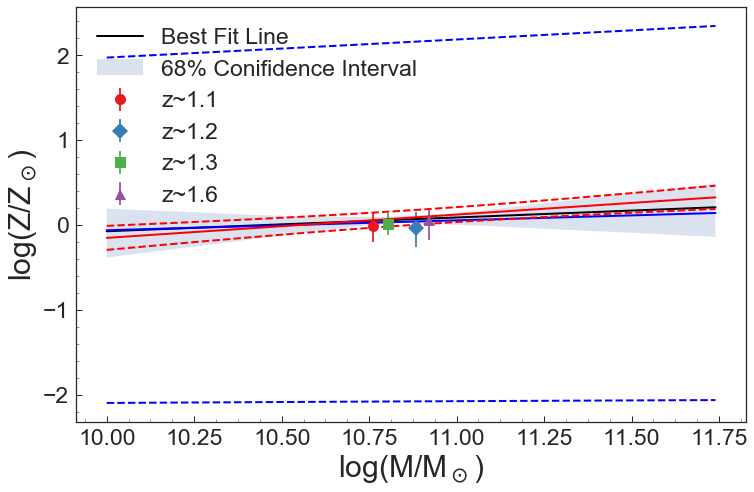

In [87]:
###PLOT
%matplotlib inline

plt.figure(figsize=[12,8])

plt.errorbar(np.median(lzDB['lmass']),np.log10(lmed/0.019), yerr=[[ller/(lmed * np.log(10))],[lher/(lmed * np.log(10))]],
             color='#e41a1c',ms=11,fmt='o',label='z~1.1')
plt.errorbar(np.median(mzDB['lmass']),np.log10(mmed/0.019),  yerr=[[mler/(mmed * np.log(10))],[mher/(mmed * np.log(10))]],
             color='#377eb8',ms=11,fmt='D',label='z~1.2')
plt.errorbar(np.median(hzDB['lmass']),np.log10(hmed/0.019),  yerr=[[hler/(hmed * np.log(10))],[hher/(hmed * np.log(10))]],
             color='#4daf4a',ms=11,fmt='s',label='z~1.3')
plt.errorbar(np.median(uhzDB['lmass']),np.log10(uhmed/0.019), yerr=[[uhler/(uhmed * np.log(10))],[uhher/(uhmed * np.log(10))]],
             color='#984ea3',ms=11,fmt='^',label='z~1.6')

plt.plot(samp,m_fit,'k',linewidth=2,label ='Best Fit Line')
plt.plot(samp,A+B*samp,'b',linewidth=2)
plt.plot(samp,A+B*samp+etest,'b--',linewidth=2)
plt.plot(samp,A+B*samp-etest,'b--',linewidth=2)
plt.plot(samp,lfit,'r',linewidth=2)
plt.plot(samp,eline+lfit,'r--',linewidth=2)
plt.plot(samp,lfit-eline,'r--',linewidth=2)
plt.fill_between(samp,low_ers,hi_ers,alpha = .2,label = '68% Conifidence Interval')


plt.xlabel('log(M/M$_\odot$)',size=30)
plt.ylabel('log(Z/Z$_\odot$)',size=30)
# plt.axis([10,11.8,-1.5,.5])
plt.tick_params(axis='both', which='major', labelsize=23)
plt.minorticks_on()

plt.gcf().subplots_adjust(bottom=0.16)
plt.legend(fontsize=23)
plt.show()
# plt.savefig('../plots/metalmass_featgroup_10-17.pdf',bbox_inches = 'tight')
plt.close()